<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/_Knn%2BINCE95_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
4/4 [==============================] - 32s 7s/step - loss: 0.6904 - accuracy: 0.5391 - val_loss: 0.6239 - val_accuracy: 0.7241
Epoch 2/10
4/4 [==============================] - 20s 5s/step - loss: 0.5596 - accuracy: 0.7304 - val_loss: 0.5700 - val_accuracy: 0.7586
Epoch 3/10
4/4 [==============================] - 25s 6s/step - loss: 0.4723 - accuracy: 0.8174 - val_loss: 0.5360 - val_accuracy: 0.6552
Epoch 4/10
4/4 [==============================] - 21s 5s/step - loss: 0.4326 - accuracy: 0.8261 - val_loss: 0.5001 - val_accuracy: 0.7931
Epoch 5/10
4/4 [==============================] - 20s 5s/step - loss: 0.3871 - accuracy: 0.8522 - val_loss: 0.4857 - val_accuracy: 0.7241
Epoch 6/10
4/4 [==============================] - 21s 6s/step - loss: 0.3655 - accuracy: 0.8435 - val_loss: 0.4740 - val_accuracy: 0.6552
Epoch 7/10
4/4 [==============================] - 22s 5s/step - loss: 0.3290 - accuracy: 0.8783 - val_loss: 0.4480 - val_accuracy: 0.8276
Epoch 8/10
4/4 [==================

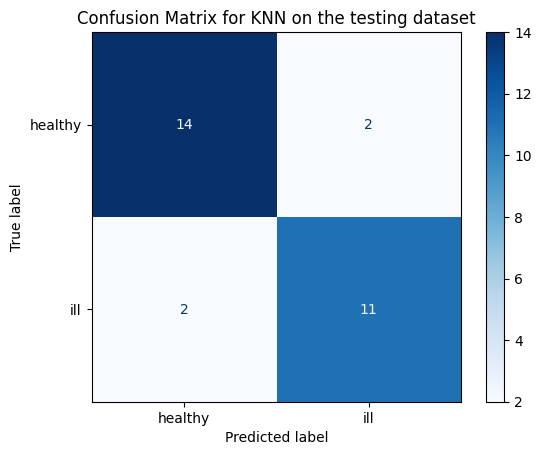

Classification Report for KNN on the training dataset:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.96      0.93      0.95        59

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115



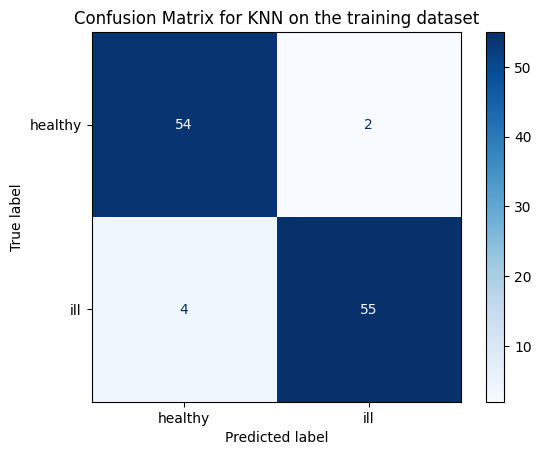

In [6]:
import os
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

np.random.seed(42)
tf.random.set_seed(42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.2, random_state=42)

# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define a range of hyperparameters to search over for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Predict on the testing dataset using the best KNN classifier with PCA features
best_knn_classifier = grid_search.best_estimator_
y_test_pred = best_knn_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for KNN on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the testing dataset")
plt.show()

# Predict on the training dataset using the best KNN classifier with PCA features
y_train_pred = best_knn_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for KNN on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the training dataset")
plt.show()

# Plot the learning curve for KNN (learning curve code remains the same)


Classification Report for KNN on the testing dataset:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.85      0.85      0.85        13

    accuracy                           0.86        29
   macro avg       0.86      0.86      0.86        29
weighted avg       0.86      0.86      0.86        29



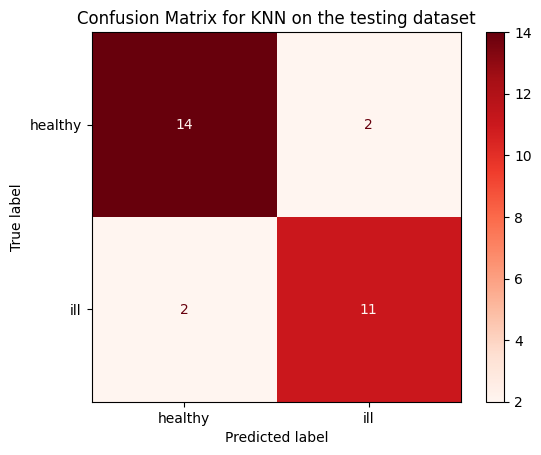

Classification Report for KNN on the training dataset:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.96      0.93      0.95        59

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115



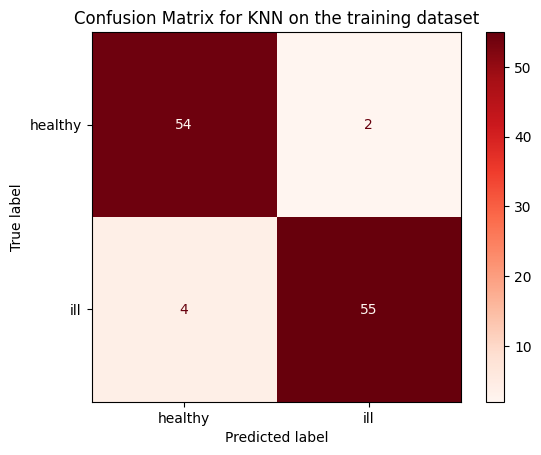

In [10]:
# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for KNN on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "ill"])
test_disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix for KNN on the testing dataset")
plt.show()

# Predict on the training dataset using the best KNN classifier with PCA features
y_train_pred = best_knn_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for KNN on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "ill"])
train_disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix for KNN on the training dataset")
plt.show()


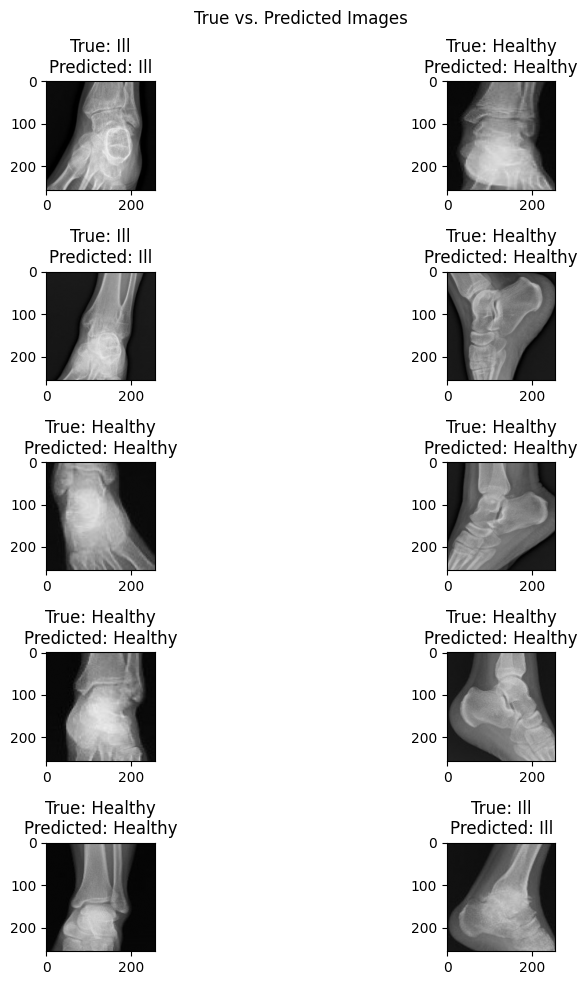

In [11]:
import random

# Randomly select some images for display (e.g., 10 images)
num_samples_to_display = 10
random_indices = random.sample(range(len(X_test)), num_samples_to_display)

# Create a figure to display the images
plt.figure(figsize=(10, 10))
plt.suptitle("True vs. Predicted Images")

# Define the number of rows and columns for image display
num_rows = 5
num_cols = 2

for i, index in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[index])  # Display the image
    true_label = "Healthy" if y_test[index] == 0 else "Ill"
    predicted_label = "Healthy" if y_test_pred[index] == 0 else "Ill"
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import recall_score


# Print classification report for the testing dataset with sensitivity and specificity
test_report = classification_report(y_test, y_test_pred, target_names=["healthy", "Ill"])

# Calculate sensitivity and specificity for testing data
sensitivity_test = recall_score(y_test, y_test_pred)
specificity_test = recall_score(y_test, y_test_pred, pos_label=0)

print("Classification Report - Testing:\n", test_report)
print("Sensitivity (True Positive Rate) - Testing:", sensitivity_test)
print("Specificity (True Negative Rate) - Testing:", specificity_test)

# Print classification report for the training dataset with sensitivity and specificity
train_report = classification_report(y_train, y_train_pred, target_names=["healthy", "Ill"])

# Calculate sensitivity and specificity for training data
sensitivity_train = recall_score(y_train, y_train_pred)
specificity_train = recall_score(y_train, y_train_pred, pos_label=0)

print("Classification Report - Training:\n", train_report)
print("Sensitivity (True Positive Rate) - Training:", sensitivity_train)
print("Specificity (True Negative Rate) - Training:", specificity_train)


Classification Report - Testing:
               precision    recall  f1-score   support

     healthy       0.88      0.88      0.88        16
         Ill       0.85      0.85      0.85        13

    accuracy                           0.86        29
   macro avg       0.86      0.86      0.86        29
weighted avg       0.86      0.86      0.86        29

Sensitivity (True Positive Rate) - Testing: 0.8461538461538461
Specificity (True Negative Rate) - Testing: 0.875
Classification Report - Training:
               precision    recall  f1-score   support

     healthy       0.93      0.96      0.95        56
         Ill       0.96      0.93      0.95        59

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115

Sensitivity (True Positive Rate) - Training: 0.9322033898305084
Specificity (True Negative Rate) - Training: 0.9642857142857143


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


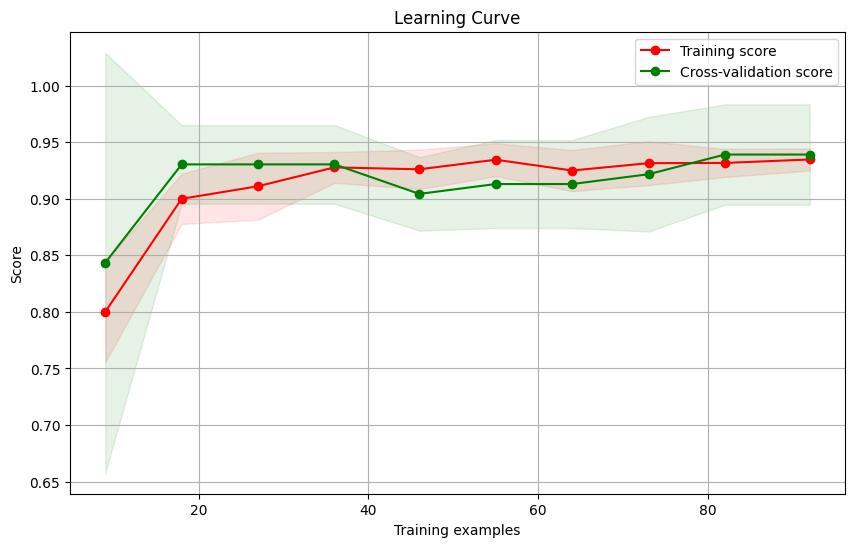

In [8]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


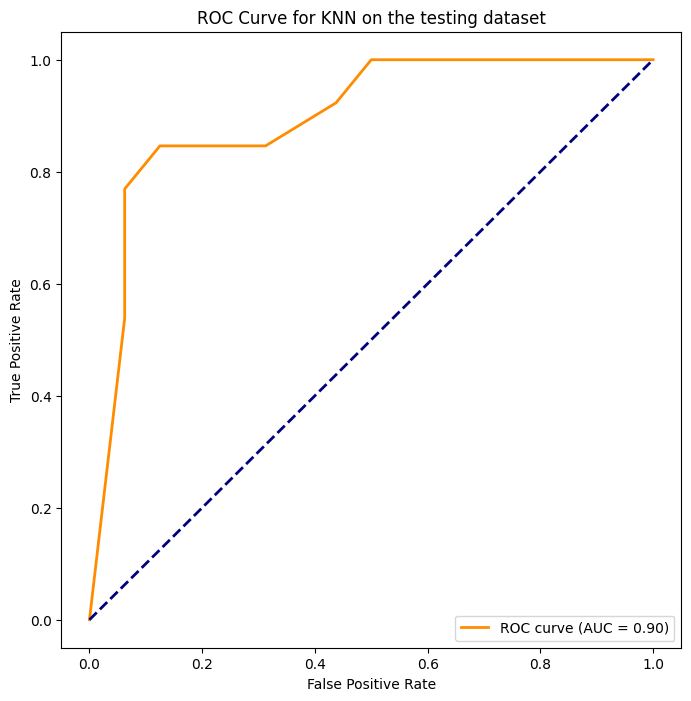

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_knn_classifier.predict_proba(X_test_pca)[:, 1])

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, best_knn_classifier.predict_proba(X_test_pca)[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN on the testing dataset')
plt.legend(loc='lower right')
plt.show()